# 2D heat transfer on a plate using pytorch

$$\frac{\partial T}{\partial t} = \alpha ( \frac{\partial ^2 T}{\partial^2 x} + \frac{\partial ^2 T}{\partial^2 y})$$

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import seaborn as sns
import numpy as np

# Check if GPU is available and set the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [ ]:
class PINN(nn.Module):
    def __init__(self):
        super(PINN, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(3, 64),
            nn.Tanh(),
            nn.Linear(64, 64),
            nn.Tanh(),
            nn.Linear(64, 64),
            nn.Tanh(),
            nn.Linear(64, 64),
            nn.Tanh(),
            nn.Linear(64, 1)
        ).to(device)

    def forward(self, x):
        return self.net(x)

In [ ]:
# IC & BC
def initial_condition(x,y):
    return (torch.sin(torch.pi * x) * torch.sin(torch.pi * y)).to(device)

In [4]:
# generating the computational domain
def generate_training_data(num_points, radius=0.2, center=(0.5, 0.5)):
    x = torch.empty(0, 1, requires_grad=True).to(device) # Move to device
    y = torch.empty(0, 1, requires_grad=True).to(device) # Move to device
    t = torch.empty(0, 1, requires_grad=True).to(device) # Move to device

    # Keep generating points until we have enough outside the hole
    while x.shape[0] < num_points:
        remaining_points = num_points - x.shape[0]
        # Generate more points than needed to account for filtering
        oversample_factor = 2
        x_temp = torch.rand(remaining_points * oversample_factor, 1, requires_grad=True).to(device) # Move to device
        y_temp = torch.rand(remaining_points * oversample_factor, 1, requires_grad=True).to(device) # Move to device
        t_temp = torch.rand(remaining_points * oversample_factor, 1, requires_grad=True).to(device) # Move to device

        # Filter out points inside the hole
        distance = torch.sqrt((x_temp - center[0])**2 + (y_temp - center[1])**2)
        mask = distance > radius

        # If no points are valid, continue to next iteration to avoid empty tensors
        if mask.sum() == 0:
            continue

        # Select valid points, ensuring 2D shape
        x_temp = x_temp[mask].view(-1, 1)
        y_temp = y_temp[mask].view(-1, 1)
        t_temp = t_temp[mask].view(-1, 1)

        # Append valid points, up to remaining_points
        num_to_append = min(remaining_points, x_temp.shape[0])
        x = torch.cat([x, x_temp[:num_to_append]], dim=0)
        y = torch.cat([y, y_temp[:num_to_append]], dim=0)
        t = torch.cat([t, t_temp[:num_to_append]], dim=0)

    # Ensure exactly num_points
    x = x[:num_points]
    y = y[:num_points]
    t = t[:num_points]
    return x, y, t


def generate_boundary_points(num_points):
    # Divide points approximately equally among four boundaries
    points_per_boundary = num_points // 4
    extra_points = num_points % 4
    # Vertical(x = 0 and x = 1)
    x_v = torch.tensor([0.0] * points_per_boundary + [1.0] * points_per_boundary, requires_grad=True).to(device) # Move to device
    y_v = torch.rand(2 * points_per_boundary, requires_grad=True).to(device) # Move to device
    # Horizontal(y = 0 and y = 1)
    x_h = torch.rand(2 * points_per_boundary, requires_grad=True).to(device) # Move to device
    y_h = torch.tensor([0.0] * points_per_boundary + [1.0] * points_per_boundary, requires_grad=True).to(device) # Move to device
    x_boundary = torch.cat([x_v, x_h])
    y_boundary = torch.cat([y_v, y_h])
    # Handle extra points if num_points is not divisible by 4
    if extra_points > 0:
        x_extra = torch.tensor([0.0, 1.0, torch.rand(1)[0], torch.rand(1)[0]], requires_grad=True).to(device) # Move to device
        y_extra = torch.rand(extra_points, requires_grad=True).to(device) # Move to device
        x_boundary = torch.cat([x_boundary, x_extra[:extra_points]])
        y_boundary = torch.cat([y_boundary, y_extra])

    return x_boundary.view(-1, 1), y_boundary.view(-1, 1)

def generate_boundary_training_data(num_points):
    x_boundary , y_boundary = generate_boundary_points(num_points)
    t = torch.rand(num_points , 1 , requires_grad=True).to(device) # Move to device
    return x_boundary , y_boundary , t

def generate_hole_boundary_points(num_points, radius=0.2, center=(0.5, 0.5)):
    theta = torch.rand(num_points, 1).to(device) * 2 * torch.pi # Move to device
    x_hole = center[0] + radius * torch.cos(theta)
    y_hole = center[1] + radius * torch.sin(theta)
    x_hole = x_hole.view(-1, 1).requires_grad_(True)
    y_hole = y_hole.view(-1, 1).requires_grad_(True)
    return x_hole, y_hole

In [ ]:
# loss
def pde(x, y, t, model):
    input_data = torch.cat([x, y, t] , dim=1)
    u = model(input_data)
    u_x , u_y = torch.autograd.grad(u, [x, y], grad_outputs=torch.ones_like(u).to(device), create_graph=True, retain_graph=True) # Move grad_outputs to device
    u_xx = torch.autograd.grad(u_x, x, grad_outputs=torch.ones_like(u_x).to(device), create_graph=True, retain_graph=True)[0] # Move grad_outputs to device
    u_yy = torch.autograd.grad(u_y, y, grad_outputs=torch.ones_like(u_y).to(device), create_graph=True, retain_graph=True)[0] # Move grad_outputs to device
    u_t = torch.autograd.grad(u, t, grad_outputs=torch.ones_like(u).to(device), create_graph=True, retain_graph=True)[0] # Move grad_outputs to device
    return 0.1 * (u_xx + u_yy) - u_t

def boundary_condition(x, y, t, model):
    input_data = torch.cat([x, y, t], dim=1)
    u = model(input_data)
    u_x, u_y = torch.autograd.grad(u, [x, y], grad_outputs=torch.ones_like(u).to(device), create_graph=True, retain_graph=True) # Move grad_outputs to device
    # Neumann condition: normal derivative = 0
    # For x=0 and x=1 boundaries
    mask_x0 = (x == 0).squeeze()
    mask_x1 = (x == 1).squeeze()
    normal_x = torch.zeros_like(x).to(device) # Move to device
    normal_x[mask_x0] = -1.0  # Normal points left at x=0
    normal_x[mask_x1] = 1.0   # Normal points right at x=1
    # For y=0 and y=1 boundaries
    mask_y0 = (y == 0).squeeze()
    mask_y1 = (y == 1).squeeze()
    normal_y = torch.zeros_like(y).to(device) # Move to device
    normal_y[mask_y0] = -1.0  # Normal points down at y=0
    normal_y[mask_y1] = 1.0   # Normal points up at y=1
    normal_derivative = u_x * normal_x + u_y * normal_y
    return normal_derivative

def neumann_condition(x_hole, y_hole, model):
    t_hole = torch.rand(x_hole.shape[0], 1, requires_grad=True).to(device) # Move to device
    input_data = torch.cat([x_hole, y_hole, t_hole], dim=1)
    u = model(input_data)
    u_x, u_y = torch.autograd.grad(u, [x_hole, y_hole], grad_outputs=torch.ones_like(u).to(device), create_graph=True, retain_graph=True) # Move grad_outputs to device
    # Normal vector for circular boundary pointing outward from the hole (cos(theta), sin(theta))
    theta = torch.atan2(y_hole - 0.5, x_hole - 0.5)
    normal_x = torch.cos(theta)
    normal_y = torch.sin(theta)
    # Neumann condition: -alpha * normal_derivative = heat_flux
    normal_derivative_val = u_x * normal_x + u_y * normal_y
    heat_flux = 0.1 * normal_derivative_val 
    return heat_flux + 1.0  

In [6]:
def train_PINN(model, num_iteration, num_points):
    optimizer = optim.Adam(model.parameters(), lr=1e-3)
    model.to(device)

    # Loss weights to balance contributions
    w_initial = 5.0
    w_boundary = 1.0
    w_pde = 1.0
    w_neumann = 1.0

    for iteration in range(num_iteration+1):
        optimizer.zero_grad()
        x, y, t = generate_training_data(num_points)
        x_b, y_b, t_b = generate_boundary_training_data(num_points)
        x_hole, y_hole = generate_hole_boundary_points(num_points)

        t_initial = torch.zeros_like(t).to(device) # Move to device
        u_initial = initial_condition(x, y)
        u_boundary = boundary_condition(x_b, y_b, t_b, model)
        residual = pde(x, y, t, model)
        neumann_residual = neumann_condition(x_hole, y_hole, model)

        loss_initial = nn.MSELoss()(u_initial, model(torch.cat([x, y, t_initial], dim=1)))
        loss_boundary = nn.MSELoss()(u_boundary, torch.zeros_like(u_boundary).to(device)) # Move to device
        loss_pde = nn.MSELoss()(residual, torch.zeros_like(residual).to(device)) # Move to device
        loss_neumann = nn.MSELoss()(neumann_residual, torch.zeros_like(neumann_residual).to(device)) # Move to device

        loss = w_initial * loss_initial + w_boundary * loss_boundary + w_pde * loss_pde + w_neumann * loss_neumann

        loss.backward()
        optimizer.step()

        if iteration % 1000 == 0:
            print(f"ITERATION: {iteration:>5} | TOTAL LOSS: {loss.item():.4f} | "
                  f"INIT: {loss_initial.item():.4f} | BC: {loss_boundary.item():.4f} | "
                  f"PDE: {loss_pde.item():.4f} | NEUMANN: {loss_neumann.item():.4f}")

In [7]:
# training the model
model = PINN()
num_iteration = 10000
num_points = 2000

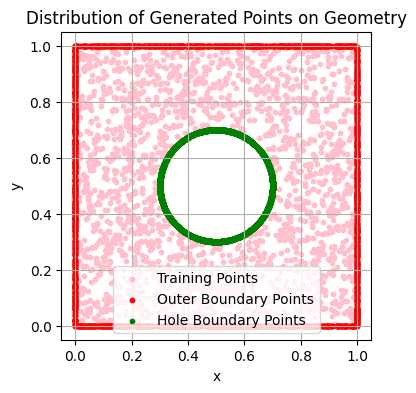

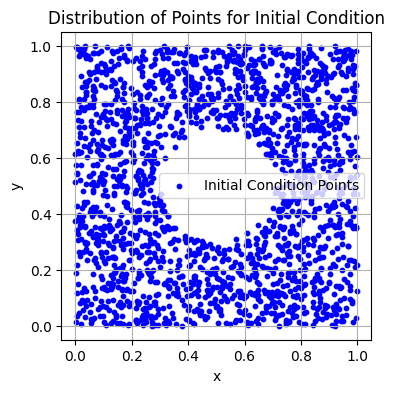

In [8]:
# Plotting the generated points before training
# Generate points for visualization
x, y, t = generate_training_data(num_points)
x_b, y_b, t_b = generate_boundary_training_data(num_points)
x_hole, y_hole = generate_hole_boundary_points(num_points)

t_initial = torch.zeros_like(t).to(device) # Move to device
x_initial, y_initial, _ = generate_training_data(num_points)

# Plot 1: Geometry with training, boundary, and hole points
plt.figure(figsize=(4, 4))
plt.scatter(x.detach().cpu().numpy(), y.detach().cpu().numpy(), color='pink', label='Training Points', s=10) # Move to CPU
plt.scatter(x_b.detach().cpu().numpy(), y_b.detach().cpu().numpy(), color='red', label='Outer Boundary Points', s=10) # Move to CPU
plt.scatter(x_hole.detach().cpu().numpy(), y_hole.detach().cpu().numpy(), color='green', label='Hole Boundary Points', s=10) # Move to CPU
plt.xlabel("x")
plt.ylabel("y")
plt.title("Distribution of Generated Points on Geometry")
plt.legend()
plt.grid(True)
plt.show()

# Plot 2: Points used for initial condition
plt.figure(figsize=(4, 4))
plt.scatter(x_initial.detach().cpu().numpy(), y_initial.detach().cpu().numpy(), color='blue', label='Initial Condition Points', s=10) # Move to CPU
plt.xlabel("x")
plt.ylabel("y")
plt.title("Distribution of Points for Initial Condition")
plt.legend()
plt.grid(True)
plt.show()

In [9]:
train_PINN(model, num_iteration, num_points)

/usr/local/lib/python3.12/dist-packages/torch/autograd/graph.py:829: UserWarning: Attempting to run cuBLAS, but there was no current CUDA context! Attempting to set the primary context... (Triggered internally at /pytorch/aten/src/ATen/cuda/CublasHandlePool.cpp:179.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


ITERATION:     0 | TOTAL LOSS: 1.8703 | INIT: 0.1738 | BC: 0.0001 | PDE: 0.0014 | NEUMANN: 0.9998
ITERATION:  1000 | TOTAL LOSS: 0.0499 | INIT: 0.0071 | BC: 0.0014 | PDE: 0.0051 | NEUMANN: 0.0080
ITERATION:  2000 | TOTAL LOSS: 0.0435 | INIT: 0.0069 | BC: 0.0016 | PDE: 0.0032 | NEUMANN: 0.0044
ITERATION:  3000 | TOTAL LOSS: 0.0416 | INIT: 0.0064 | BC: 0.0017 | PDE: 0.0030 | NEUMANN: 0.0048
ITERATION:  4000 | TOTAL LOSS: 0.0376 | INIT: 0.0057 | BC: 0.0025 | PDE: 0.0032 | NEUMANN: 0.0035
ITERATION:  5000 | TOTAL LOSS: 0.0302 | INIT: 0.0043 | BC: 0.0029 | PDE: 0.0027 | NEUMANN: 0.0029
ITERATION:  6000 | TOTAL LOSS: 0.0279 | INIT: 0.0037 | BC: 0.0024 | PDE: 0.0031 | NEUMANN: 0.0039
ITERATION:  7000 | TOTAL LOSS: 0.0207 | INIT: 0.0025 | BC: 0.0020 | PDE: 0.0028 | NEUMANN: 0.0032
ITERATION:  8000 | TOTAL LOSS: 0.0167 | INIT: 0.0020 | BC: 0.0019 | PDE: 0.0029 | NEUMANN: 0.0021
ITERATION:  9000 | TOTAL LOSS: 0.0129 | INIT: 0.0011 | BC: 0.0014 | PDE: 0.0040 | NEUMANN: 0.0020
ITERATION: 10000 | T

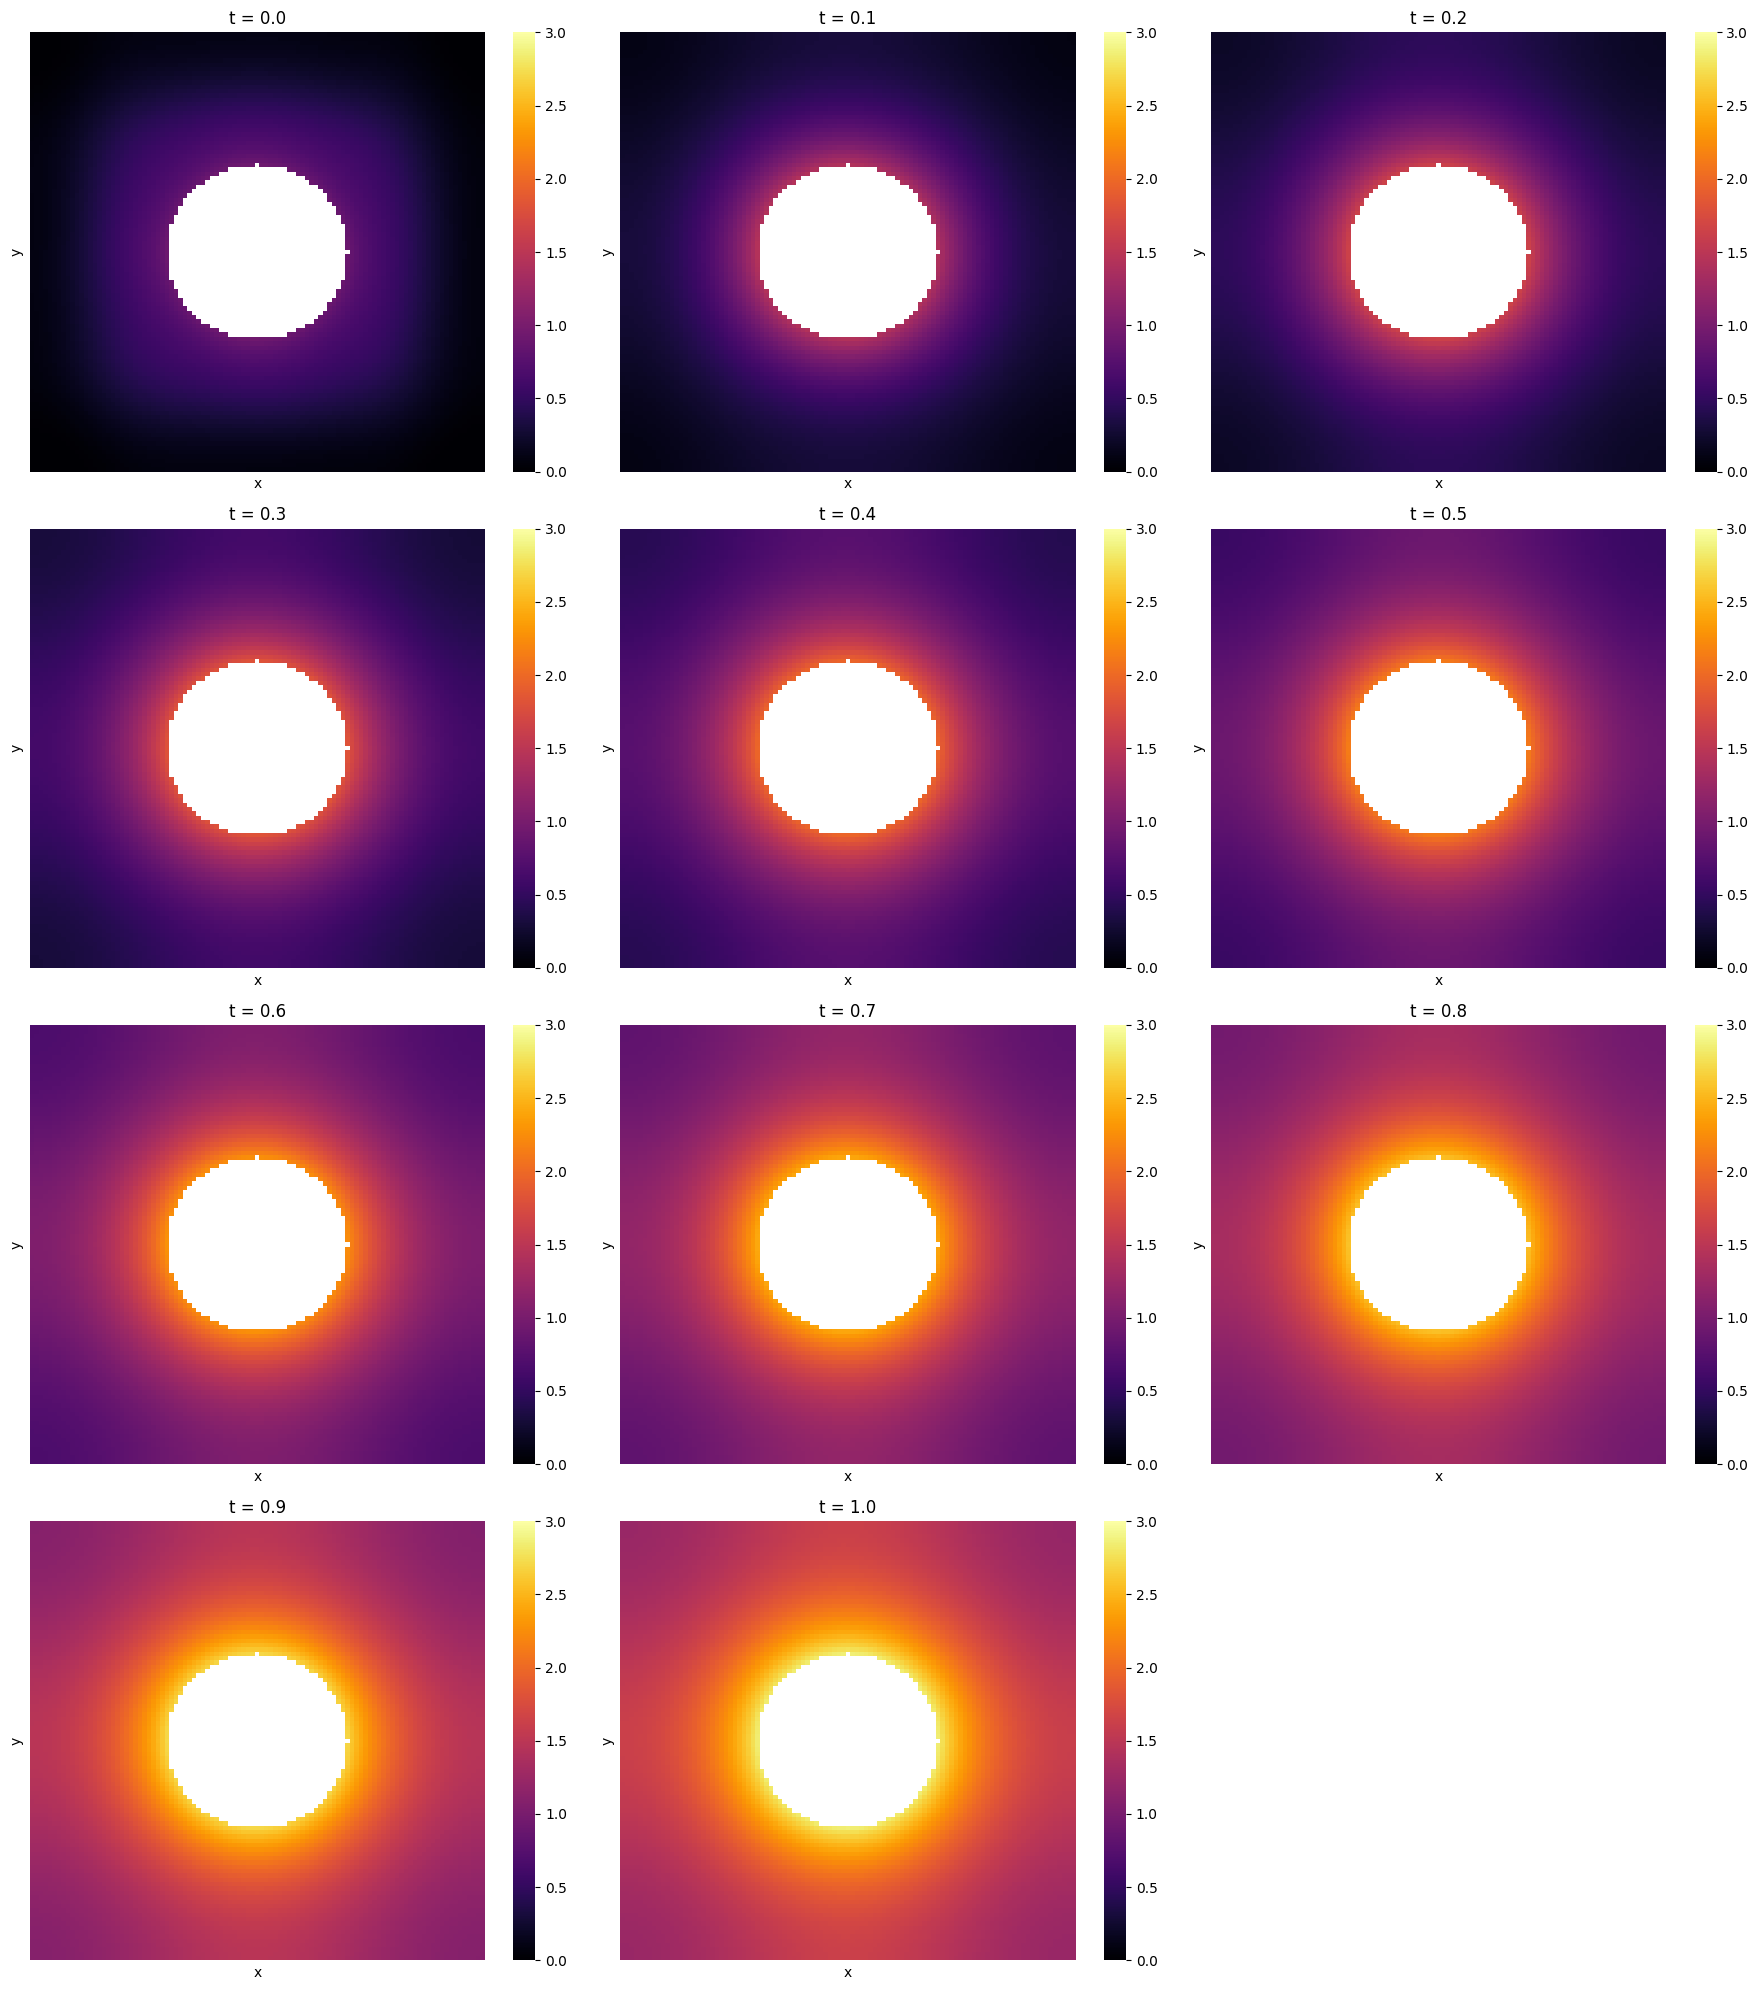

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns

# Spatial resolution for plotting
x_vals = torch.linspace(0, 1, 100+1)
y_vals = torch.linspace(0, 1, 100+1)
X, Y = torch.meshgrid(x_vals, y_vals)

# Time steps to visualize
time_steps_to_plot = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]

# Create a 3x4 grid of subplots
fig, axes = plt.subplots(4, 3, figsize=(18, 20))
axes = axes.flatten() # Flatten the 2D array of axes for easier iteration

# Iterate through the time steps and plot the heatmap
for i, t in enumerate(time_steps_to_plot):
    if i < len(axes): # Ensure we don't go out of bounds
        # Create input data for the model for the current time step
        t_val = torch.full_like(X, t)
        input_data = torch.stack([X.flatten(), Y.flatten(), t_val.flatten()], dim=1).to(device)

        # Get model prediction
        with torch.no_grad():
            solution_data = model(input_data).reshape(X.shape , Y.shape)


        # Apply mask for the circular hole (radius=0.2, center=(0.5, 0.5))
        mask = (X - 0.5)**2 + (Y - 0.5)**2 <= 0.2**2
        solution_data = solution_data.clone()  # Avoid modifying the original tensor
        solution_data[mask] = float('nan')  # Mask the hole region
        solution_data = solution_data.cpu().numpy()

        # Plot the heatmap
        sns.heatmap(solution_data, cmap="inferno", vmin=0, vmax=3, ax=axes[i], cbar=True) # Set cbar to True
        axes[i].set_title(f"t = {t:.1f}")
        axes[i].set_xlabel("x")
        axes[i].set_ylabel("y")
        axes[i].invert_yaxis() # Invert y-axis to match spatial orientation
        axes[i].set_xticks([]) # Remove x-axis ticks
        axes[i].set_yticks([]) # Remove y-axis ticks


# Hide any unused subplots
for j in range(len(time_steps_to_plot), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

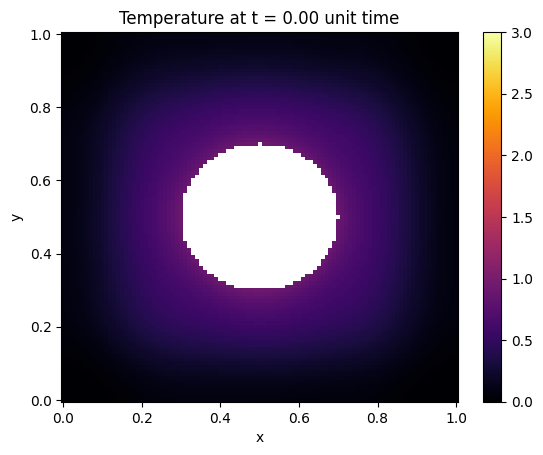

In [13]:
# Parameters
nelx = 100
nely = 100
timesteps = 101
x = np.linspace(0, 1, nelx+1)
y = np.linspace(0, 1, nely+1)
t = np.linspace(0, 1, timesteps)
delta_t = t[1] - t[0]
xx, yy = np.meshgrid(x, y)

# Prepare for animation
fig = plt.figure()
ax = fig.add_subplot(111)
Ts = []

# Evaluate model at each timestep
for time in t:
    with torch.no_grad():
        x_vals = torch.linspace(0, 1, nelx+1).to(device) # Move to device
        y_vals = torch.linspace(0, 1, nely+1).to(device) # Move to device
        X, Y = torch.meshgrid(x_vals, y_vals)
        t_val = torch.ones_like(X).to(device) * time # Move to device

        input_data = torch.stack([X.flatten(), Y.flatten(), t_val.flatten()], dim=1)
        solution = model(input_data).reshape(X.shape)

        # Apply mask for the circular hole (radius=0.2, center=(0.5, 0.5))
        mask = (X.cpu() - 0.5)**2 + (Y.cpu() - 0.5)**2 < 0.2**2 # Perform mask calculation on CPU
        solution = solution.clone()  # Avoid modifying the original tensor
        solution[mask.to(device)] = float('nan')  # Apply mask on the device

        # Convert to numpy and scale if needed
        T = solution.cpu().numpy() # Move to CPU for numpy conversion
        Ts.append(T)

# Animation function
def plotheatmap(T, time):
    plt.clf()
    plt.title(f"Temperature at t = {time*delta_t:.2f} unit time")
    plt.xlabel("x")
    plt.ylabel("y")
    plt.pcolormesh(xx, yy, T, cmap='inferno', vmin=0, vmax=3)
    plt.colorbar()
    return plt

def animate(k):
    plotheatmap(Ts[k], k)

# Create and save animation
anim = animation.FuncAnimation(fig, animate, interval=50, frames=len(t), repeat=False)
anim.save("central_hole_heat_source.gif", writer='pillow', fps=10)

In [14]:
import pandas as pd

# Generate evaluation points
x_vals = np.linspace(0, 1, 10+1)
y_vals = np.linspace(0, 1, 10+1)
t_vals = np.linspace(0, 1, 10+1) # timesteps from 0 to 1

# Create a base DataFrame with X and Y coordinates
X, Y = np.meshgrid(x_vals, y_vals)
df = pd.DataFrame({
    'X': X.ravel(),
    'Y': Y.ravel()
})

# Sort by X then Y
df = df.sort_values(by=['X', 'Y']).reset_index(drop=True)

# Add columns for each timestep and populate with model predictions
for t in t_vals:
    # Create grid for current time step
    points = np.vstack([X.ravel(), Y.ravel(), np.full_like(X.ravel(), t)]).T

    # Convert to torch tensors and move to device
    x_torch = torch.FloatTensor(points[:, 0]).unsqueeze(1).to(device) # Move to device
    y_torch = torch.FloatTensor(points[:, 1]).unsqueeze(1).to(device) # Move to device
    t_torch = torch.FloatTensor(points[:, 2]).unsqueeze(1).to(device) # Move to device

    # Model prediction
    with torch.no_grad():
        input_data = torch.cat([x_torch, y_torch, t_torch], dim=1)
        model_pred = model(input_data).cpu().numpy().flatten() # Move back to CPU for numpy

    # Apply mask for points inside the circular hole (radius=0.2, center=(0.5, 0.5))
    distances = np.sqrt((points[:, 0] - 0.5)**2 + (points[:, 1] - 0.5)**2)
    mask = distances < 0.19999
    model_pred[mask] = np.nan  # Set NaN for points inside the circle

    # Add model predictions to the DataFrame for the current timestep, formatted to 3 decimal places
    df[f't={t:.1f}'] = [f"{val:.3f}" if not np.isnan(val) else np.nan for val in model_pred[df.index]] # Assign based on sorted index and format

# Save to CSV
df.to_csv('central_hole_heat_source.csv', index=False)
print("CSV file saved with time-sorted data!")

CSV file saved with time-sorted data!
